In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path = "/content/drive/MyDrive/Colab Notebooks/data"

In [ ]:
!pip install bertopic
!pip install sentence_transformers
!pip install textblob
!pip install seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.7/154.7 kB 3.4 MB/s eta 0:00:00


In [ ]:
import pandas as pd
from bertopic import BERTopic
from sklearn.feature_extraction.text import CountVectorizer
import glob
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from sentence_transformers import SentenceTransformer
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from textblob import TextBlob
import seaborn as sns
import os

/usr/local/lib/python3.12/dist-packages/hdbscan/robust_single_linkage_.py:175: SyntaxWarning: invalid escape sequence '\{'
  $max \{ core_k(a), core_k(b), 1/\alpha d(a,b) \}$.


In [ ]:
# Format text files into dataframe
def convert_text_files(directories, label):
    texts = []
    labels = []
    years = []
    for directory in directories:
        text_files = glob.glob(f"{directory}/*.txt")
        for file_path in text_files:
            try:
                with open(file_path, 'r', encoding='utf-8') as f:
                    text = f.read().strip()
                    if text:  # Only add non-empty texts
                        current_year = None
                        if "GrimmFairyTale" in directory: # Corrected comparison to check for 'GrimmFairyTale' in the directory path
                            current_year = 1812
                        else:
                            try:
                                # Attempt to extract year from filename for other directories
                                year_str = file_path.split('_')[-1].replace('.txt', '')
                                current_year = int(year_str)
                            except ValueError:
                                # If year cannot be parsed, print a warning and skip this file
                                print(f"Warning: Could not parse year from file name {file_path}. Skipping this file to maintain data integrity.")
                                continue # Skip appending text, label, and year for this file

                        # If current_year was successfully determined (either hardcoded or parsed), append all data
                        texts.append(text)
                        labels.append(label)
                        years.append(current_year)

            except Exception as e:
                print(f"Error reading {file_path}: {e}")

    return pd.DataFrame({'Texts': texts, 'Labels': labels, 'Years': years})

In [ ]:
df = convert_text_files(directories=[f"{path}/fiction_text_files/", f"{path}/Fan_text_files/", f"{path}/GrimmFairyTale/"], label='fiction')

# Create time periods for stories
df['Era'] = df['Years'].apply(lambda x:
    'Lovecraft (1917-1937)' if x <= 1937 else
    'Post-Lovecraft (1938-1970)' if x <= 1970 else
    'Modern (1971-2000)' if x <= 2000 else
    'Contemporary (2001+)'
)

In [ ]:
# Set up stop words
custom_stop_words = ['said', 'went', 'came', 'saw', 'looked', 'seemed',
                     'knew', 'told', 'asked', 'thought', 'felt', 'heard',
                     'began', 'made', 'found']

all_stop_words = list(ENGLISH_STOP_WORDS.union(set(custom_stop_words)))

vectorizer = CountVectorizer(stop_words=all_stop_words, min_df=2, ngram_range=(1, 2), max_features=2000)

# Set up embedding model that has been proven to provide better accuracy for semantic meanings. Slower but higher accuracy
embedding_model = SentenceTransformer('all-mpnet-base-v2')

# Initialize BERTopic model
topic_model = BERTopic(
    embedding_model=embedding_model,
    vectorizer_model=vectorizer, #Stop words
    min_topic_size=2, #minimum number of documents per topic
    verbose=False,
    calculate_probabilities=True, # Calculate probability of each document belonging to which topic
    nr_topics=5
)

# Fit the model on text data
topics, probs = topic_model.fit_transform(df['Texts'])

# Store entire probability matrix for potential future use
all_document_probabilities = probs

# Add topics back to dataframe
df['Topic'] = topics
df['Topic_Probability'] = probs.max(axis=1)

# Get topic information
topic_info = topic_model.get_topic_info()
print("\n=== Topic Information ===")
print(topic_info)

# Display documents with their topics
#print("\n=== Documents with Assigned Topics ===")
# print(df[['Texts', 'Labels', 'Topic', 'Topic_Probability']])

# Get representative words for each topic
print("\n=== Top Words per Topic ===")
for topic_num in topic_info['Topic']:
    if topic_num != -1:  # Skip outlier topic
        print(f"\nTopic {topic_num}:")
        print(topic_model.get_topic(topic_num))
print(len(topic_info))

if len(topic_info) > 2:
    fig = topic_model.visualize_topics()
    fig.show()

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]


=== Topic Information ===
   Topic  Count                      Name  \
0     -1     51   -1_like_carter_time_did   
1      0    209  0_king_little_away_shall   
2      1    137       1_like_time_old_man   
3      2     13    2_nadia_pike_like_time   
4      3      3       3_sam_mike_like_eye   

                                      Representation  \
0  [like, carter, time, did, great, old, man, kno...   
1  [king, little, away, shall, took, man, did, co...   
2  [like, time, old, man, did, just, things, eyes...   
3  [nadia, pike, like, time, just, professor, shi...   
4  [sam, mike, like, eye, didn, just, room, wasn,...   

                                 Representative_Docs  
0  [In everything, it’s as much who you know as w...  
1  [There was once a man whose wife died, and a w...  
2  [During the winter of 1927–28 officials of the...  
3  [(Found Among the Papers of the Late\nFrancis ...  
4  [Danny came back from Afghan with little black...  

=== Top Words per Topic ===

Topic

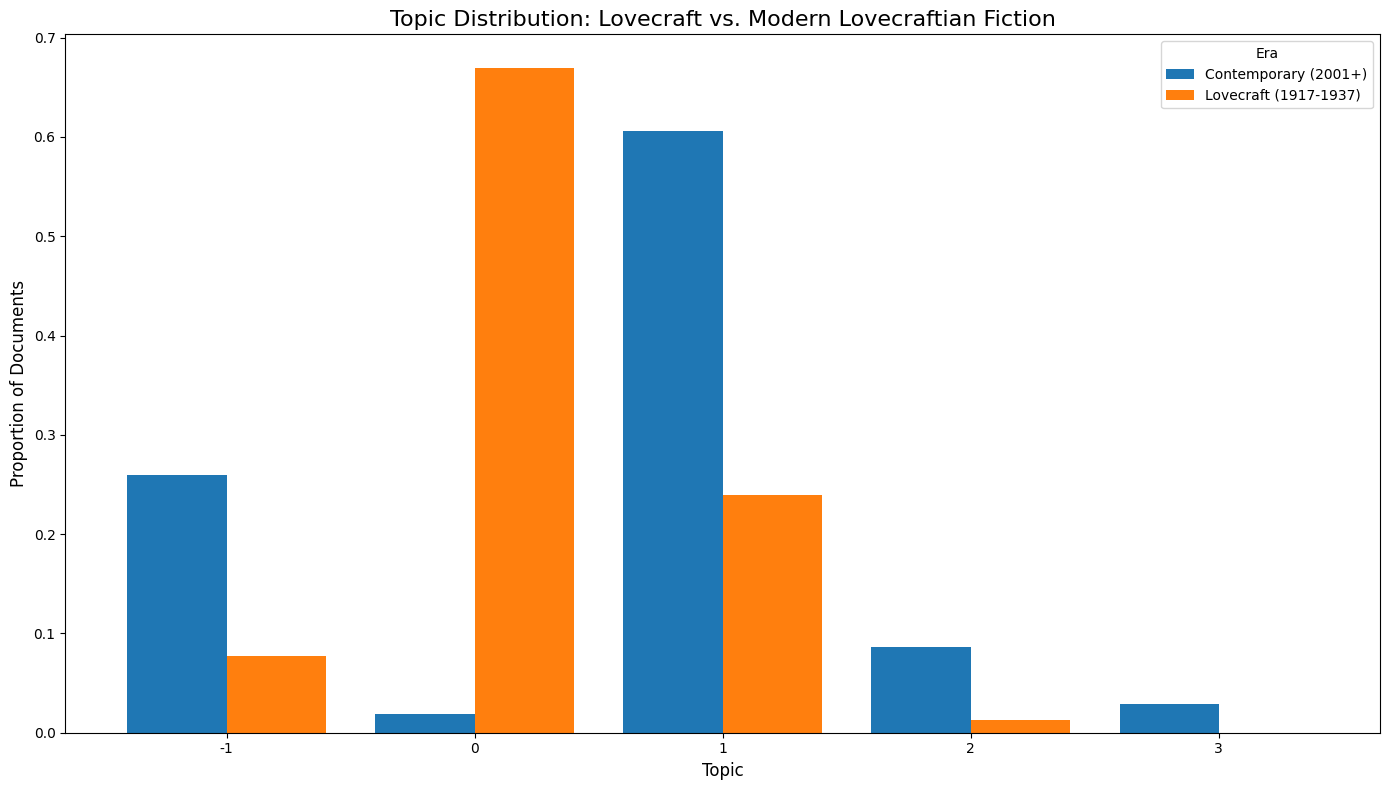


=== Topic Proportions ===
Era    Contemporary (2001+)  Lovecraft (1917-1937)
Topic                                             
-1                 0.259615               0.077670
 0                 0.019231               0.669903
 1                 0.605769               0.239482
 2                 0.086538               0.012945
 3                 0.028846               0.000000


In [ ]:
# Compare topic prevalence between eras
def compare_era_topics(df):
    """Compare topic distributions between different eras of lovecraft's works"""

    # Get topic counts per era
    era_topics = df.groupby(['Era', 'Topic']).size().reset_index(name='Count')

    # Calculate proportions (Evenly distribute which is important for unequal corpus sizes)
    era_totals = df.groupby('Era').size().to_dict()
    era_topics['Proportion'] = era_topics.apply(lambda row: row['Count'] / era_totals[row['Era']], axis=1)

    # Create comparison visualization
    pivot_prop = era_topics.pivot(index='Topic', columns='Era', values='Proportion').fillna(0)

    # Plot
    fig, ax = plt.subplots(figsize=(14, 8))
    pivot_prop.plot(kind='bar', ax=ax, width=0.8)
    plt.title('Topic Distribution: Lovecraft vs. Modern Lovecraftian Fiction', fontsize=16)
    plt.xlabel('Topic', fontsize=12)
    plt.ylabel('Proportion of Documents', fontsize=12)
    plt.legend(title='Era', fontsize=10)
    plt.xticks(rotation=0)
    plt.tight_layout()
    # plt.savefig('lovecraft_vs_modern_topics.png', dpi=300)
    plt.show()

    return pivot_prop

proportions = compare_era_topics(df)
print("\n=== Topic Proportions ===")
print(proportions)

In [ ]:
def analyze_vocabulary_shift(df):
    """Compare distinctive vocabulary between eras"""

    # Get top words per era
    era_vocab = {}
    for era in df['Era'].unique():
        era_texts = ' '.join(df[df['Era'] == era]['Texts'].values)

        vectorizer = TfidfVectorizer(max_features=50, stop_words=all_stop_words)
        tfidf_matrix = vectorizer.fit_transform([era_texts])

        # Get top words
        feature_names = vectorizer.get_feature_names_out()
        scores = tfidf_matrix.toarray()[0]
        top_words = sorted(zip(feature_names, scores), key=lambda x: x[1], reverse=True)

        era_vocab[era] = top_words[:20]

    # Display comparison
    for era, words in era_vocab.items():
        print(f"\n=== Top Words in {era} ===")
        for word, score in words:
            print(f"{word}: {score:.4f}")

    return era_vocab

top_words_per_era = analyze_vocabulary_shift(df)


=== Top Words in Lovecraft (1917-1937) ===
old: 0.2794
did: 0.2707
man: 0.2504
time: 0.2498
great: 0.2221
like: 0.2210
little: 0.2134
king: 0.1800
long: 0.1720
come: 0.1712
away: 0.1710
night: 0.1659
things: 0.1568
house: 0.1396
took: 0.1367
day: 0.1346
know: 0.1317
way: 0.1310
door: 0.1244
just: 0.1233

=== Top Words in Contemporary (2001+) ===
like: 0.4247
just: 0.2786
time: 0.2384
eyes: 0.2305
man: 0.2062
know: 0.1821
didn: 0.1770
did: 0.1704
face: 0.1650
don: 0.1623
away: 0.1529
head: 0.1527
way: 0.1497
old: 0.1441
hand: 0.1404
long: 0.1326
right: 0.1193
door: 0.1164
ve: 0.1141
room: 0.1127



=== Sentiment Analysis by Era ===
                      Sentiment         Subjectivity        
                           mean     std         mean     std
Era                                                         
Contemporary (2001+)     0.0284  0.0493       0.4585  0.0379
Lovecraft (1917-1937)    0.0699  0.0805       0.4882  0.0513


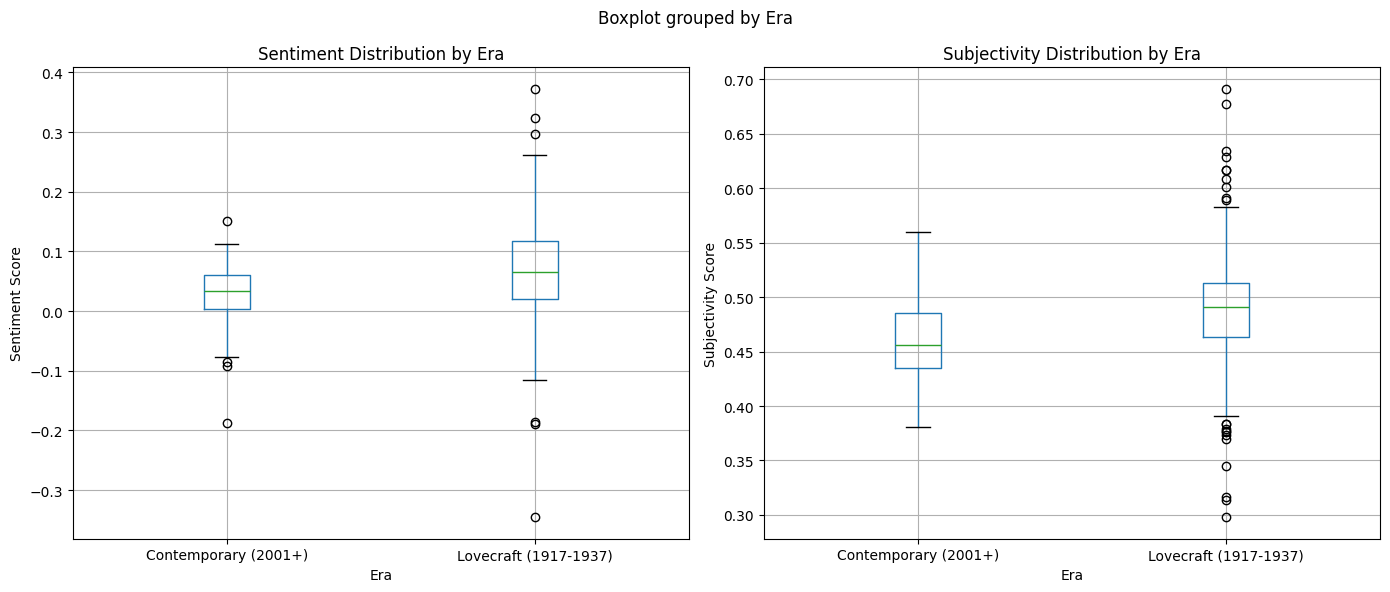

Sentiment         Subjectivity        
                           mean     std         mean     std
Era                                                         
Contemporary (2001+)     0.0284  0.0493       0.4585  0.0379
Lovecraft (1917-1937)    0.0699  0.0805       0.4882  0.0513

In [ ]:
def analyze_sentiment_over_time(df):
    """Track how sentiment changes over time"""

    # Calculate sentiment scores
    df['Sentiment'] = df['Texts'].apply(lambda x: TextBlob(x).sentiment.polarity)
    df['Subjectivity'] = df['Texts'].apply(lambda x: TextBlob(x).sentiment.subjectivity)

    # Compare eras
    era_sentiment = df.groupby('Era').agg({
        'Sentiment': ['mean', 'std'],
        'Subjectivity': ['mean', 'std']
    }).round(4)

    print("\n=== Sentiment Analysis by Era ===")
    print(era_sentiment)

    # Visualize
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

    df.boxplot(column='Sentiment', by='Era', ax=ax1)
    ax1.set_title('Sentiment Distribution by Era')
    ax1.set_xlabel('Era')
    ax1.set_ylabel('Sentiment Score')

    df.boxplot(column='Subjectivity', by='Era', ax=ax2)
    ax2.set_title('Subjectivity Distribution by Era')
    ax2.set_xlabel('Era')
    ax2.set_ylabel('Subjectivity Score')

    plt.tight_layout()
    plt.show()

    return era_sentiment


# Sentiment mean [-1, +1] measures overall emotional tone of text, -1 is very negative and +1 is very positive, 0 is neutral
# Sentiment std measures how much sentiment varies within text or across documents (low means less fluctuation, high means a lot)
# Subjectivity mean measure how opinion-based vs factual the text is (0 means very objective, 1 means very opinionated)
# Subjectivity std measures variation in objectivity thought text (Low std means consistently objective or consistently subjective, high std means switches back and forth)
analyze_sentiment_over_time(df)

# Alex's alternative approach for the project

In [ ]:
# All data label information (for reference)
df

,Texts,Labels,Years,Era,Topic,Topic_Probability,Sentiment,Subjectivity
0,"Somewhere, to what remote and fearsome region ...",fiction,1921,Lovecraft (1917-1937),1,1.000000,-0.020019,0.495891
1,An Extemporaneous Sob Story\nby Marcus Lollius...,fiction,1919,Lovecraft (1917-1937),-1,0.782315,0.105083,0.503323
2,"“Hello, Bruce. Haven’t seen you in a dog’s age...",fiction,1923,Lovecraft (1917-1937),1,1.000000,0.041111,0.430939
3,It was on a certain Thursday morning in Decemb...,fiction,1931,Lovecraft (1917-1937),-1,0.466915,0.058524,0.467884
4,Original title Al Azif—azif being the word use...,fiction,1927,Lovecraft (1917-1937),1,1.000000,-0.032667,0.482045
...,...,...,...,...,...,...,...,...
408,A young drummer went out quite alone one eveni...,fiction,1812,Lovecraft (1917-1937),0,0.629961,0.115179,0.471567
409,"Hill and vale do not meet, but the children of...",fiction,1812,Lovecraft (1917-1937),0,0.850854,0.093589,0.445551
410,There was once a sorcerer who was standing in ...,fiction,1812,Lovecraft (1917-1937),0,1.000000,0.185385,0.370000
411,"There was once a cook named Gretel, who wore s...",fiction,1812,Lovecraft (1917-1937),0,0.681977,0.155440,0.510195


In [ ]:
# Import necessary modules / libraries for Logistic Regression, metric
# calculation, and graph visualization
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [ ]:
# Implements Multinomial Logistic Regression to calculate predictions from
# vectorized versions of various stories and their assigned topic numbers and
# comparing them with their assigned eras
def logistic_regression(df):
  # Initializes training (X) and testing (y) data and separates text data for
  # TF-IDF vectorization and topic number data
  X_text = df['Texts']
  X_topic = df['Topic']
  y = df['Era']

  # Splits the feature matrix (text and topic numbers) and target data into
  # training and testing data
  X_text_train, X_text_test, X_topic_train, X_topic_test, y_train, y_test = train_test_split(X_text, X_topic, y, test_size=0.2, random_state=42)

  # Defines a TF-IDF vectorizer to numerically embed each document
  vectorizer = TfidfVectorizer(max_features=50, stop_words=all_stop_words)
  X_train_tfidf = vectorizer.fit_transform(X_text_train)
  X_test_tfidf = vectorizer.transform(X_text_test)

  # Combines numerical feature matrix data
  X_train_tfidf_df = pd.DataFrame(X_train_tfidf.toarray(), index=X_text_train.index)
  X_test_tfidf_df = pd.DataFrame(X_test_tfidf.toarray(), index=X_text_test.index)

  # Creates new training and testing data frames for topics
  X_topic_train_df = pd.DataFrame(X_topic_train.values, columns=['Topic'], index=X_topic_train.index)
  X_topic_test_df = pd.DataFrame(X_topic_test.values, columns=['Topic'], index=X_topic_test.index)

  # Concatenates TF-IDF vectors and topics for training and testing data
  X_train_combined = pd.concat([X_train_tfidf_df, X_topic_train_df], axis=1)
  X_test_combined = pd.concat([X_test_tfidf_df, X_topic_test_df], axis=1)
  X_train_combined.columns = X_train_combined.columns.astype(str)
  X_test_combined.columns = X_test_combined.columns.astype(str)

  # Uses a Multinomial Logistic Regression model to fit the training data
  model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000)
  model.fit(X_train_combined, y_train)

  # Predicts the target data with the combined test data
  y_pred = model.predict(X_test_combined)

  # Returns the test and prediction target data
  return y_test, y_pred

y_test, y_pred = logistic_regression(df)
print(y_test, "\n")
print(f"Era Predictions:\n{y_pred}\n")
print(f"Era Counts:\nLovecraft: {np.sum(y_pred == 'Lovecraft (1917-1937)')}")
print(f"Contemporary: {np.sum(y_pred == 'Contemporary (2001+)')}")

394    Lovecraft (1917-1937)
349    Lovecraft (1917-1937)
400    Lovecraft (1917-1937)
353    Lovecraft (1917-1937)
181     Contemporary (2001+)
               ...          
287    Lovecraft (1917-1937)
322    Lovecraft (1917-1937)
202     Contemporary (2001+)
274    Lovecraft (1917-1937)
389    Lovecraft (1917-1937)
Name: Era, Length: 83, dtype: object 

Era Predictions:
['Lovecraft (1917-1937)' 'Lovecraft (1917-1937)' 'Lovecraft (1917-1937)'
 'Lovecraft (1917-1937)' 'Contemporary (2001+)' 'Lovecraft (1917-1937)'
 'Lovecraft (1917-1937)' 'Lovecraft (1917-1937)' 'Lovecraft (1917-1937)'
 'Contemporary (2001+)' 'Lovecraft (1917-1937)' 'Lovecraft (1917-1937)'
 'Lovecraft (1917-1937)' 'Lovecraft (1917-1937)' 'Contemporary (2001+)'
 'Contemporary (2001+)' 'Lovecraft (1917-1937)' 'Lovecraft (1917-1937)'
 'Contemporary (2001+)' 'Lovecraft (1917-1937)' 'Lovecraft (1917-1937)'
 'Lovecraft (1917-1937)' 'Lovecraft (1917-1937)' 'Lovecraft (1917-1937)'
 'Lovecraft (1917-1937)' 'Lovecraft (1917-1937

In [ ]:
# Utilizes classification to calculate all metrics
def metric_classification(y_test, y_pred):
  # Calculates sklearn metrics
  acc = accuracy_score(y_test, y_pred)
  prec = precision_score(y_test, y_pred, average='weighted')
  recall = recall_score(y_test, y_pred, average='weighted')
  f1 = f1_score(y_test, y_pred, average='weighted')

  # Returns all metric values
  return acc, prec, recall, f1


acc, prec, recall, f1 = metric_classification(y_test, y_pred)
print(f"Accuracy: {acc:.6f}")
print(f"Precision: {prec:.6f}")
print(f"Recall: {recall:.6f}")
print(f"F1-Score: {f1:.6f}")

Accuracy: 0.951807
Precision: 0.951134
Recall: 0.951807
F1-Score: 0.950555


In [ ]:
# Defines a list of labels that include the names of both eras for visualization
x_and_y_labels = ['Lovecraft (1917-1937)', 'Contemporary (2001+)']

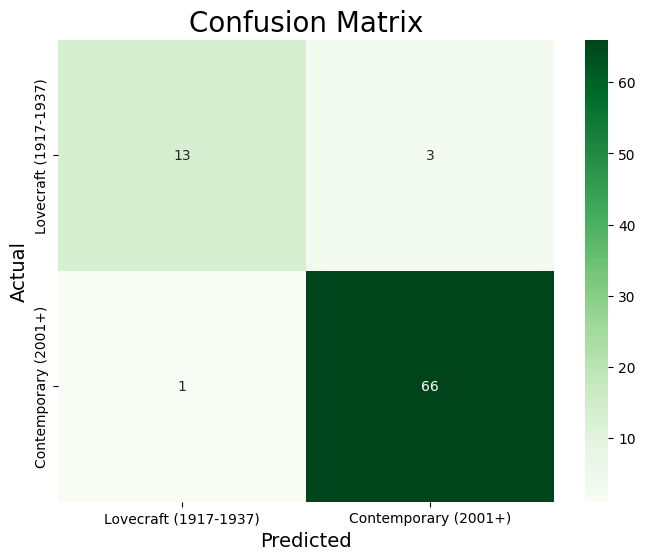

In [ ]:
# Calculates the confusion matrix for Era Prediction
def calculate_confusion_matrix(y_test, y_pred):
  # Defines the matrix using true and predicted data
  matrix = confusion_matrix(y_test, y_pred)

  # Visualizes the matrix as a heat map
  plt.figure(figsize=(8, 6))
  sns.heatmap(matrix, annot=True, cmap='Greens', xticklabels=x_and_y_labels, yticklabels=x_and_y_labels)
  plt.title('Confusion Matrix', fontsize=20)
  plt.xlabel('Predicted', fontsize=14)
  plt.ylabel('Actual', fontsize=14)
  plt.show()


calculate_confusion_matrix(y_test, y_pred)

In [ ]:
# Generate and print the classification report
report = classification_report(y_test, y_pred)
print(f"Classification Report:\n{report}")

Classification Report:
                       precision    recall  f1-score   support

 Contemporary (2001+)       0.93      0.81      0.87        16
Lovecraft (1917-1937)       0.96      0.99      0.97        67

             accuracy                           0.95        83
            macro avg       0.94      0.90      0.92        83
         weighted avg       0.95      0.95      0.95        83

